In [1]:
from random import sample

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from sklearn.metrics import roc_auc_score

import torch
from torch.nn import ReLU
from torch.nn import Dropout
from torch.nn import Linear, ModuleList, Sequential
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

In [2]:
def fp_from_smi(smi, nbits=2048):
    mol = Chem.MolFromSmiles(smi)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=nbits)

    fingerprint = np.zeros((0, ), dtype=np.uint8)
    DataStructs.ConvertToNumpyArray(fp, fingerprint)
    return fingerprint

In [3]:
def sample_batch_backprop_net(pos_X, neg_X, pos_y, neg_y, batch_size):
    n_half = batch_size // 2
    pos_sample_idx = sample(range(len(pos_X)), n_half)
    neg_sample_idx = sample(range(len(neg_X)), n_half)
    
    X_out = np.append(pos_X[pos_sample_idx], neg_X[neg_sample_idx],axis=0)
    y_out = np.append(pos_y[pos_sample_idx], neg_y[neg_sample_idx],axis=0)
    return X_out, y_out

def sample_batch_ff_net(pos_X, neg_X, batch_size):
    n_half = batch_size // 2
    pos_sample_idx = sample(range(len(pos_X)), n_half)
    neg_sample_idx = sample(range(len(neg_X)), n_half)
    
    return pos_X[pos_sample_idx], neg_X[neg_sample_idx]

In [4]:
class BackpropagationDenseNet(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims, dropout=0.0):
        super().__init__()
        
        hidden_dims = [input_dim] + hidden_dims + [output_dim]
        layers = []
        for (in_dim, out_dim) in zip(hidden_dims[:-1], hidden_dims[1:]):
            layers.append(Linear(in_dim, out_dim))
            layers.append(ReLU())
            if dropout > 0:
                layers.append(Dropout(p=dropout))
        if dropout > 0:
            self.mlp = Sequential(*layers[:-2])
        else:
            self.mlp = Sequential(*layers[:-1])
            
    def forward(self, x):
        return self.mlp(x)

Adapted from this [pytorch_forward_forward](https://github.com/mohammadpz/pytorch_forward_forward) repo.

In [13]:
class ForwardForwardNet(torch.nn.Module):
    def __init__(self, input_dim, hidden_dims, dropout=0.0):
        super().__init__()
        
        hidden_dims = [input_dim] + hidden_dims
        self.layers = []
        for (in_dim, out_dim) in zip(hidden_dims[:-1], hidden_dims[1:]):
            self.layers += [Layer(in_dim, out_dim, dropout)]
        
    def predict(self, x):
        h = x
        goodness = []
        for layer in self.layers:
            h = layer(h)
            goodness += [h.pow(2).mean(1)]
        
        ## TODO: verify the correct dimension
        return sum(goodness)

    def ff_train(self, x_pos, x_neg):
        h_pos, h_neg = x_pos, x_neg
        for i, layer in enumerate(self.layers):
            h_pos, h_neg = layer.train(h_pos, h_neg)
            
        
class Layer(torch.nn.Module):
    def __init__(self, in_dim, out_dim, dropout=0, threshold=2.0, opt_iters=50, lr=0.001):
        super().__init__()
        
        self.threshold = threshold
        self.opt_iters = opt_iters

        layers = []
        layers.append(Linear(in_dim, out_dim))
        layers.append(ReLU())
        if dropout > 0:
            layers.append(Dropout(p=dropout))
            
        if dropout > 0:
            self.mlp = Sequential(*layers[:-2])
        else:
            self.mlp = Sequential(*layers[:-1])
            
        self.optimizer = Adam(self.parameters(), lr=lr)
            
    def forward(self, x):
        x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4)
        return self.mlp(x_direction)

    def train(self, x_pos, x_neg):
        for i in range(self.opt_iters):
            g_pos = self.forward(x_pos).pow(2).mean(1)
            g_neg = self.forward(x_neg).pow(2).mean(1)
            loss = torch.log(1 + torch.exp(torch.cat([-g_pos + self.threshold, g_neg - self.threshold]))).mean()
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        return self.forward(x_pos).detach(), self.forward(x_neg).detach()

In [6]:
def eval_dense_model(model, X_test, y_test, batch_size):
    y_true = []
    y_pred = []
    
    # Can we do it better? In one step?
    model.eval()
    for idx in range(0, len(y_test), batch_size):
        X_ = X_test[idx:idx + batch_size]
        X_ = torch.tensor(X_).float()
        y_ = y_test[idx:idx + batch_size]
        
        out = model(X_)
        
        y_hat = torch.max(out, 1)
        
        y_true.append(torch.tensor(y_))
        y_pred.append(y_hat[1])
        
    y_true = torch.cat(y_true, dim=0).numpy()
    y_pred = torch.cat(y_pred, dim=0).numpy()
    
    y_true = np.squeeze(np.asarray(y_true))
    y_pred = np.squeeze(np.asarray(y_pred))

    return roc_auc_score(y_true, y_pred)

In [9]:
# TODO: print some stats, number of actives, number of inactives
train_file = './data/drd2.test.csv'
test_file = './data/drd2.test.csv'

train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file).sample(frac=1)

train_df_pos = train_df[train_df['activity'] == 1]
train_df_neg = train_df[train_df['activity'] == 0]

train_X_arr_pos = np.array([fp_from_smi(smi) for smi in list(train_df_pos.canonical)])
train_y_arr_pos = np.array(list(train_df_pos.activity))
train_X_arr_neg = np.array([fp_from_smi(smi) for smi in list(train_df_neg.canonical)])
train_y_arr_neg = np.array(list(train_df_neg.activity))

test_X_arr = np.array([fp_from_smi(smi) for smi in list(test_df.canonical)])
test_y_arr = np.array(list(test_df.activity))

In [ ]:
input_dim = 2048
num_iters = 50
batch_size = 128
lr = 0.001
dropout = 0.0
hidden_dims = [256, 256]

In [11]:
dense_model = BackpropagationDenseNet(input_dim=input_dim, output_dim=2,
                                      hidden_dims=hidden_dims, dropout=dropout)

optimizer = Adam(dense_model.parameters(), lr=lr)

loss_ce = CrossEntropyLoss()
for iter in range(num_iters):
    dense_model.train()
    optimizer.zero_grad()
    (X,y) = sample_batch_backprop_net(train_X_arr_pos, train_X_arr_neg, 
                                    train_y_arr_pos, train_y_arr_neg, batch_size=batch_size)
    
    
    X_tensor = torch.tensor(X).float()
    out = dense_model(X_tensor)
    loss = loss_ce(out.squeeze(), torch.tensor(y).type(torch.LongTensor))
    print(f'Iter: {iter}, Test ROC-AUC: {eval_dense_model(dense_model, test_X_arr, test_y_arr, batch_size)}')
    loss.backward()
    optimizer.step()

Iter: 0, Test ROC-AUC: 0.5000073441929467
Iter: 1, Test ROC-AUC: 0.5037969477534114
Iter: 2, Test ROC-AUC: 0.6083464361508034
Iter: 3, Test ROC-AUC: 0.7759882522187505
Iter: 4, Test ROC-AUC: 0.8716014917340896
Iter: 5, Test ROC-AUC: 0.9149648832691166
Iter: 6, Test ROC-AUC: 0.9307834664192438
Iter: 7, Test ROC-AUC: 0.9366996265762974
Iter: 8, Test ROC-AUC: 0.9400575566869149
Iter: 9, Test ROC-AUC: 0.941080850407504
Iter: 10, Test ROC-AUC: 0.9428091781408974
Iter: 11, Test ROC-AUC: 0.9425219376489762
Iter: 12, Test ROC-AUC: 0.9449038985546203
Iter: 13, Test ROC-AUC: 0.9467701320199953
Iter: 14, Test ROC-AUC: 0.9502969785683855
Iter: 15, Test ROC-AUC: 0.9535977890694344
Iter: 16, Test ROC-AUC: 0.9578974098112255
Iter: 17, Test ROC-AUC: 0.9555138234816503
Iter: 18, Test ROC-AUC: 0.9575122609301377
Iter: 19, Test ROC-AUC: 0.9584890385920405
Iter: 20, Test ROC-AUC: 0.9618665418704183
Iter: 21, Test ROC-AUC: 0.9611345649666883
Iter: 22, Test ROC-AUC: 0.964130170211841
Iter: 23, Test ROC-AUC:

In [14]:
ff_model = ForwardForwardNet(input_dim=input_dim, hidden_dims=hidden_dims, dropout=dropout)

for iter in range(num_iters):
    ff_model.train()
    (X_pos, X_neg) = sample_batch_ff_net(train_X_arr_pos, train_X_arr_neg, batch_size=batch_size)
    
    
    X_pos = torch.tensor(X_pos).float()
    X_neg = torch.tensor(X_neg).float()
    
    ff_model.ff_train(X_pos, X_neg)
    
    y_pred = ff_model.predict(torch.tensor(test_X_arr).float())
    y_pred = y_pred.detach().numpy()
    ROC_AUC = roc_auc_score(test_y_arr, y_pred)
    print(f'Iter: {iter}, Test ROC-AUC: {ROC_AUC}')

 20%|██        | 10/50 [00:00<00:00, 94.27it/s]

Iter: 0, Test ROC-AUC: 0.8567442574836263


 16%|█▌        | 8/50 [00:00<00:00, 75.89it/s]

Iter: 1, Test ROC-AUC: 0.8966580228721145


 16%|█▌        | 8/50 [00:00<00:00, 77.74it/s]

Iter: 2, Test ROC-AUC: 0.9189197694662088


 16%|█▌        | 8/50 [00:00<00:00, 79.04it/s]

Iter: 3, Test ROC-AUC: 0.9445561429340277


 16%|█▌        | 8/50 [00:00<00:00, 79.67it/s]

Iter: 4, Test ROC-AUC: 0.959117592579339


 16%|█▌        | 8/50 [00:00<00:00, 77.99it/s]

Iter: 5, Test ROC-AUC: 0.9690884365588444


 16%|█▌        | 8/50 [00:00<00:00, 78.84it/s]

Iter: 6, Test ROC-AUC: 0.9744657133671613


 16%|█▌        | 8/50 [00:00<00:00, 77.74it/s]

Iter: 7, Test ROC-AUC: 0.978861097959739


 12%|█▏        | 6/50 [00:00<00:00, 56.02it/s]

Iter: 8, Test ROC-AUC: 0.9813229769603562


 16%|█▌        | 8/50 [00:00<00:00, 74.84it/s]

Iter: 9, Test ROC-AUC: 0.9824196189996092


 16%|█▌        | 8/50 [00:00<00:00, 77.47it/s]

Iter: 10, Test ROC-AUC: 0.9837027167369631


 18%|█▊        | 9/50 [00:00<00:00, 82.35it/s]

Iter: 11, Test ROC-AUC: 0.9846134221925649


 16%|█▌        | 8/50 [00:00<00:00, 77.29it/s]

Iter: 12, Test ROC-AUC: 0.9854742075603046


 16%|█▌        | 8/50 [00:00<00:00, 79.18it/s]

Iter: 13, Test ROC-AUC: 0.9852836159667554


 14%|█▍        | 7/50 [00:00<00:00, 66.11it/s]

Iter: 14, Test ROC-AUC: 0.9865731813595429


 18%|█▊        | 9/50 [00:00<00:00, 82.13it/s]

Iter: 15, Test ROC-AUC: 0.9867506674407656


 16%|█▌        | 8/50 [00:00<00:00, 74.40it/s]

Iter: 16, Test ROC-AUC: 0.9875001155242402


 14%|█▍        | 7/50 [00:00<00:00, 65.28it/s]

Iter: 17, Test ROC-AUC: 0.9883281796615282


 18%|█▊        | 9/50 [00:00<00:00, 84.76it/s]

Iter: 18, Test ROC-AUC: 0.9891636475622734


 16%|█▌        | 8/50 [00:00<00:00, 79.07it/s]

Iter: 19, Test ROC-AUC: 0.9895555023808376


 16%|█▌        | 8/50 [00:00<00:00, 76.14it/s]

Iter: 20, Test ROC-AUC: 0.9901693850023887


 18%|█▊        | 9/50 [00:00<00:00, 88.58it/s]

Iter: 21, Test ROC-AUC: 0.99073697282715


 18%|█▊        | 9/50 [00:00<00:00, 89.66it/s]

Iter: 22, Test ROC-AUC: 0.9907633710734076


 12%|█▏        | 6/50 [00:00<00:00, 55.29it/s]

Iter: 23, Test ROC-AUC: 0.9909761569371826


 18%|█▊        | 9/50 [00:00<00:00, 86.18it/s]

Iter: 24, Test ROC-AUC: 0.9913033522215536


 16%|█▌        | 8/50 [00:00<00:00, 80.00it/s]

Iter: 25, Test ROC-AUC: 0.9915587480205357


 16%|█▌        | 8/50 [00:00<00:00, 79.10it/s]

Iter: 26, Test ROC-AUC: 0.9917639258791029


 16%|█▌        | 8/50 [00:00<00:00, 71.62it/s]

Iter: 27, Test ROC-AUC: 0.991779746104697


 12%|█▏        | 6/50 [00:00<00:00, 55.80it/s]

Iter: 28, Test ROC-AUC: 0.9921800088753254


  8%|▊         | 4/50 [00:00<00:01, 39.57it/s]

Iter: 29, Test ROC-AUC: 0.9925102848061005


 10%|█         | 5/50 [00:00<00:00, 49.36it/s]

Iter: 30, Test ROC-AUC: 0.9926038190177766


  8%|▊         | 4/50 [00:00<00:01, 39.29it/s]

Iter: 31, Test ROC-AUC: 0.9926405314724368


 10%|█         | 5/50 [00:00<00:00, 49.58it/s]

Iter: 32, Test ROC-AUC: 0.9926827329241428


  6%|▌         | 3/50 [00:00<00:01, 29.25it/s]

Iter: 33, Test ROC-AUC: 0.9927729737375917


  8%|▊         | 4/50 [00:00<00:01, 36.17it/s]

Iter: 34, Test ROC-AUC: 0.9928858768752775


 12%|█▏        | 6/50 [00:00<00:00, 52.31it/s]

Iter: 35, Test ROC-AUC: 0.9930901441560401


  8%|▊         | 4/50 [00:00<00:01, 36.19it/s]

Iter: 36, Test ROC-AUC: 0.9930611673576817


 10%|█         | 5/50 [00:00<00:00, 47.52it/s]

Iter: 37, Test ROC-AUC: 0.9934929088881126


 12%|█▏        | 6/50 [00:00<00:00, 55.03it/s]

Iter: 38, Test ROC-AUC: 0.9940185080129911


 12%|█▏        | 6/50 [00:00<00:00, 57.04it/s]

Iter: 39, Test ROC-AUC: 0.9940977367920563


 12%|█▏        | 6/50 [00:00<00:00, 56.70it/s]

Iter: 40, Test ROC-AUC: 0.9940994047663523


 10%|█         | 5/50 [00:00<00:01, 44.18it/s]

Iter: 41, Test ROC-AUC: 0.9937826853817695


  8%|▊         | 4/50 [00:00<00:01, 39.02it/s]

Iter: 42, Test ROC-AUC: 0.9941096423840984


  8%|▊         | 4/50 [00:00<00:01, 37.54it/s]

Iter: 43, Test ROC-AUC: 0.9940270351060762


 12%|█▏        | 6/50 [00:00<00:00, 57.49it/s]

Iter: 44, Test ROC-AUC: 0.9940539439567104


 12%|█▏        | 6/50 [00:00<00:00, 57.68it/s]

Iter: 45, Test ROC-AUC: 0.994093703017483


 10%|█         | 5/50 [00:00<00:01, 44.76it/s]

Iter: 46, Test ROC-AUC: 0.9941308920362277


 12%|█▏        | 6/50 [00:00<00:00, 56.67it/s]

Iter: 47, Test ROC-AUC: 0.9942127929781959


 12%|█▏        | 6/50 [00:00<00:00, 56.41it/s]

Iter: 48, Test ROC-AUC: 0.9943215006499229


100%|██████████| 50/50 [00:00<00:00, 215.75it/s]


Iter: 49, Test ROC-AUC: 0.994549247221925


(array([1.75224593e-01, 3.27324779e-01, 1.29264054e-01, 1.70238475e-02,
        3.81403356e-03, 9.22285193e-04, 3.07428302e-04, 1.24892826e-04,
        1.92142689e-05, 3.84285617e-05]),
 array([7.8804762e-04, 1.5296915e+00, 3.0585949e+00, 4.5874982e+00,
        6.1164017e+00, 7.6453052e+00, 9.1742086e+00, 1.0703113e+01,
        1.2232016e+01, 1.3760920e+01, 1.5289823e+01], dtype=float32),
 <a list of 10 Patch objects>)

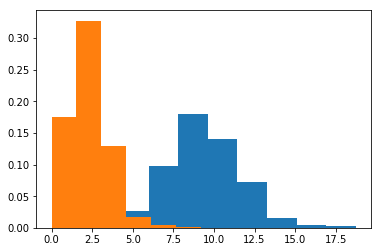

In [61]:
plt.hist(y_pred[test_y_arr==1], density=True)
plt.hist(y_pred[test_y_arr==0], density=True)